<a href="https://colab.research.google.com/github/saba-ramezani/Fine-Tuning-DistilBERT-MobileBERT-and-TinyBERT-for-Fake-News-Detection/blob/main/Fine_Tuning_DistilBERT_MobileBERT_TinyBERT_For_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning DistilBERT, MobileBERT and TinyBERT for Fake News Detection

## 1. Load the Fake news dataset

In [ ]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install seaborn --upgrade

# !pip install -U openpyxl

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")

In [ ]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [ ]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
df.shape

df['label'].value_counts()

,count
label,
0,10361
1,7920


## 2. Dataset Analysis

In [ ]:
import matplotlib.pyplot as plt

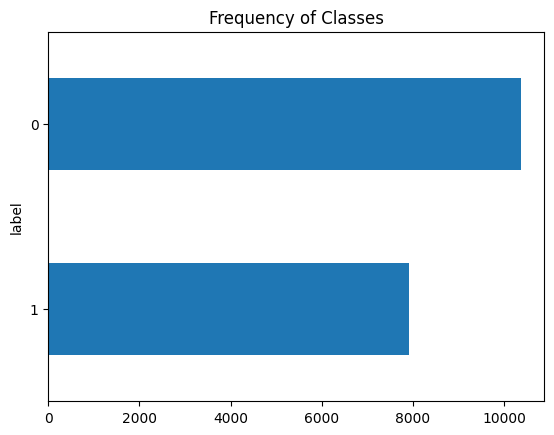

In [ ]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

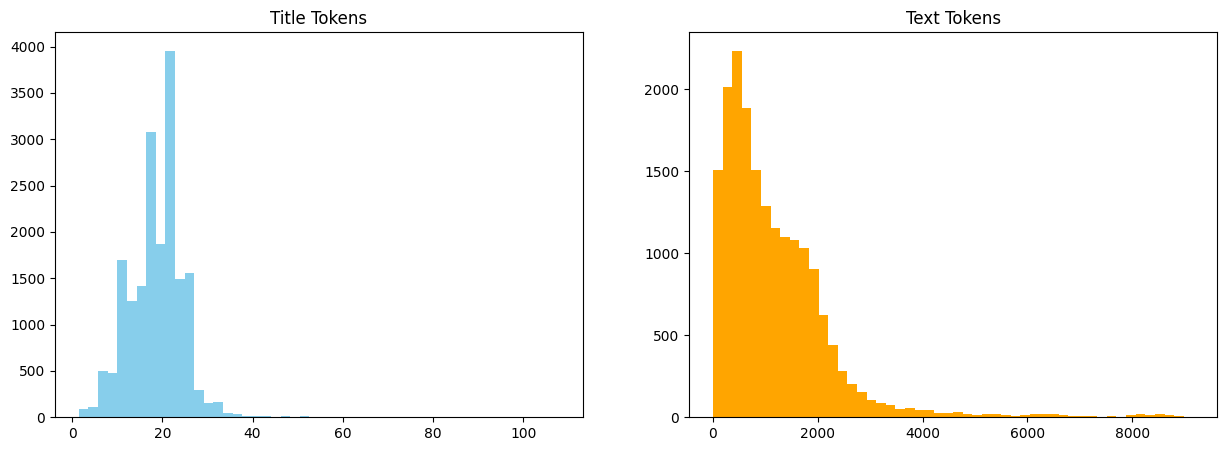

In [ ]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)


fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

## 3. Data Loader & Train, Test, Val split

In [ ]:
from sklearn.model_selection import train_test_split

# 70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape

((12796, 7), (3656, 7), (1829, 7), (18281, 7))

In [ ]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## 4. Data Tokenization using Distilbert


In [ ]:
from transformers import AutoTokenizer

text = "We are trying to tokenize this text :)"

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)


In [ ]:
distilbert_tokens

['we', 'are', 'trying', 'to', 'token', '##ize', 'this', 'text', ':', ')']

In [ ]:
distilbert_tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
def tokenize(batch):
    temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1520, 2292, 2023, 2450, 1521, 1055, 9191, 4861, 14113, 1996, 6397, 2545, 2125, 1521, 1011, 1996, 2047, 2259, 2335, 102], [101, 12316, 9681, 999, 18520, 3632, 2125, 1996, 15168, 1529, 8005, 1037, 4922, 4670, 1031, 2678, 1033, 102, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]}


In [ ]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens', 'input_ids', 'attention_mask'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens', 'input_ids', 'attention_mask'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens', 'input_ids', 'attention_mask'],
        num_rows: 1829
    })
})

## 5. Build the distilbert model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"


num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)


In [ ]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.56.0",
  "vocab_size": 30522
}

## 6. Fine-tune the model

In [ ]:
# !pip install evaluate


In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"



training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    report_to="none"
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenizer
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Step,Training Loss
500,0.102300
1000,0.084400
1500,0.139200
2000,0.075600
2500,0.038500
3000,0.045600
3500,0.018500
4000,0.014900
4500,0.009000


TrainOutput(global_step=4800, training_loss=0.055340080360571545, metrics={'train_runtime': 444.9269, 'train_samples_per_second': 86.279, 'train_steps_per_second': 10.788, 'total_flos': 979298361414144.0, 'train_loss': 0.055340080360571545, 'epoch': 3.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/llm_finetuning_transformers/Fake_News_Detection/distilbert-base-uncased-news-detection-model")

## 7. Evaluate the model

In [ ]:
preds_output = trainer.predict(encoded_dataset['test'])


In [ ]:
preds_output.metrics

{'test_loss': 0.24616140127182007,
 'test_accuracy': 0.9614332603938731,
 'test_runtime': 10.0724,
 'test_samples_per_second': 362.971,
 'test_steps_per_second': 45.371}

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.96      0.97      0.97      2072
        Fake       0.96      0.95      0.96      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## 8. Benchmarking (Bert, DistilBert, MobileBert, TinyBert)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp

    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )

    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics


import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()

    model_performance[model_name] = {model_name:result, "time taken": end-start}

In [ ]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.19665861129760742,
   'test_accuracy': 0.9660831509846827,
   'test_f1': 0.9660754900151514,
   'test_runtime': 19.2405,
   'test_samples_per_second': 190.016,
   'test_steps_per_second': 23.752},
  'time taken': 1000.4434232711792},
 'distilbert': {'distilbert': {'test_loss': 0.20278647541999817,
   'test_accuracy': 0.9636214442013129,
   'test_f1': 0.9636146110702504,
   'test_runtime': 9.6041,
   'test_samples_per_second': 380.671,
   'test_steps_per_second': 47.584},
  'time taken': 528.9954595565796},
 'mobilebert': {'mobilebert': {'test_loss': 0.19624720513820648,
   'test_accuracy': 0.9636214442013129,
   'test_f1': 0.9636033788195353,
   'test_runtime': 18.9623,
   'test_samples_per_second': 192.804,
   'test_steps_per_second': 24.1},
  'time taken': 847.3755266666412},
 'tinybert': {'tinybert': {'test_loss': 0.2633061707019806,
   'test_accuracy': 0.9480306345733042,
   'test_f1': 0.9477151099418942,
   'test_runtime': 2.8715,
   'te

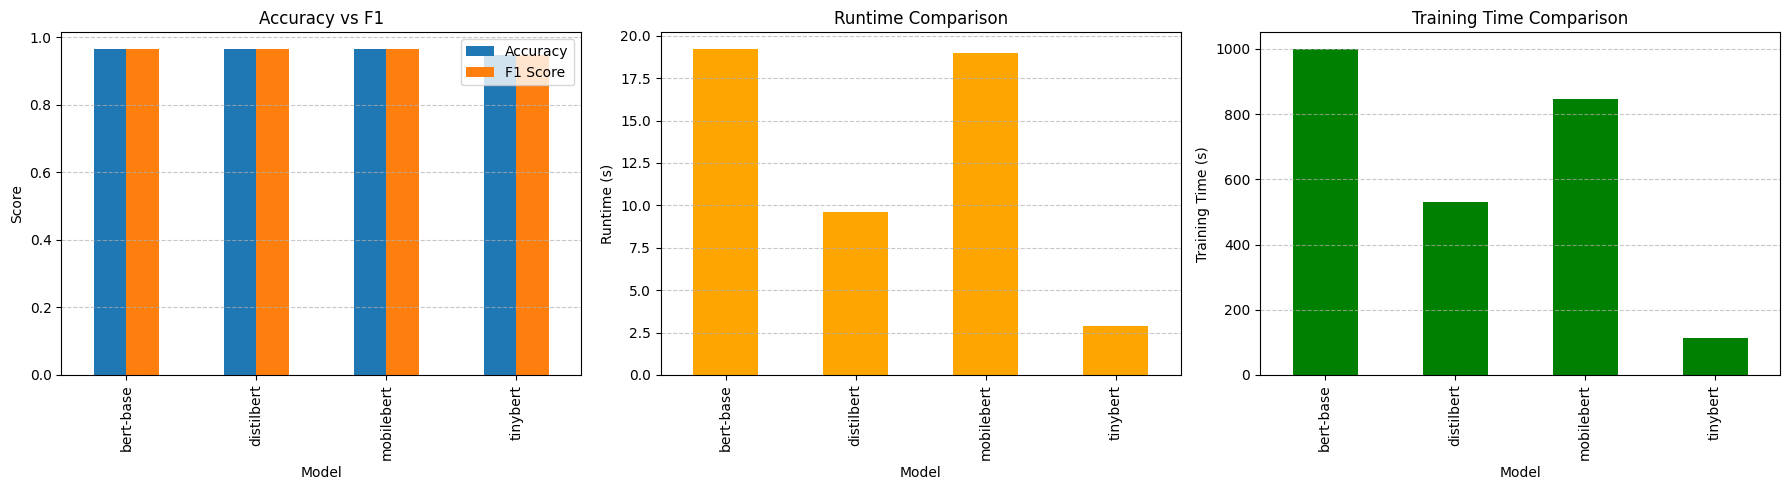

In [ ]:
# Extract into DataFrame
rows = []
for model, results in model_performance.items():
    inner = results[model]
    rows.append({
        "Model": model,
        "Accuracy": inner['test_accuracy'],
        "F1 Score": inner['test_f1'],
        "Runtime (s)": inner['test_runtime'],
        "Training Time (s)": results['time taken']
    })

df = pd.DataFrame(rows)

#3 bar charts side by side
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Accuracy vs F1 (bar)
df.plot(x="Model", y=["Accuracy", "F1 Score"], kind="bar", ax=axes[0])
axes[0].set_title("Accuracy vs F1")
axes[0].set_ylabel("Score")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Runtime
df.plot(x="Model", y="Runtime (s)", kind="bar", color="orange", ax=axes[1], legend=False)
axes[1].set_title("Runtime Comparison")
axes[1].set_ylabel("Runtime (s)")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Training Time
df.plot(x="Model", y="Training Time (s)", kind="bar", color="green", ax=axes[2], legend=False)
axes[2].set_title("Training Time Comparison")
axes[2].set_ylabel("Training Time (s)")
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()




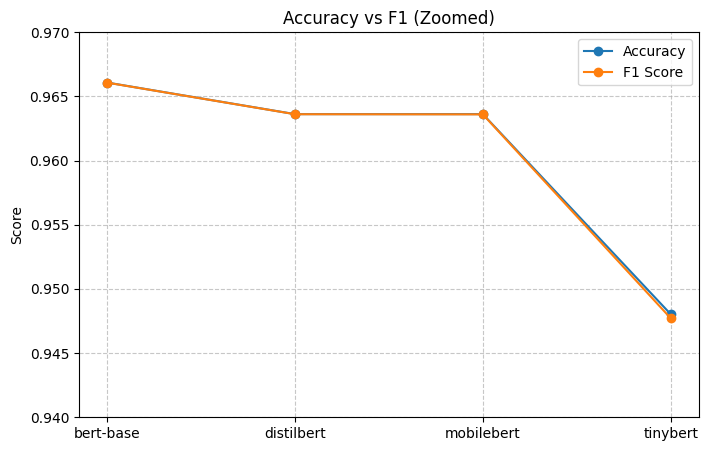

In [ ]:
# Line chart with zoom for Accuracy & F1
plt.figure(figsize=(8,5))
plt.plot(df["Model"], df["Accuracy"], marker="o", label="Accuracy")
plt.plot(df["Model"], df["F1 Score"], marker="o", label="F1 Score")

plt.ylim(0.94, 0.97)
plt.title("Accuracy vs F1 (Zoomed)")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()